In [2]:
import copy
import datasets
import itertools
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

os.sys.path.append('/data/kai/forecasting/multimodal/financial')

from templates.PROMPTS import ForecstBaselinePrompts
from src.vllm import llm_chat

from queue import Queue
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from threading import Thread
import numpy as np

In [2]:
ticker = 'AAPL'

save_dir = '/data/kai/forecasting/results'
os.makedirs(save_dir, exist_ok=True)
baseline_path = os.path.join(save_dir, f'{ticker}_baseline.csv')
df = pd.read_csv(baseline_path)

In [3]:
def convert_to_float(values):
    return np.array([[float(num) for num in val.replace(' ', '').split(',')] for val in values])
results = convert_to_float(df['Result'].values)
ground_truth = convert_to_float(df['Ground Truth'].values)

In [4]:
max_truth = ground_truth.max(1)[:, np.newaxis]
min_truth = ground_truth.min(1)[:, np.newaxis]
normalized_results = (results - max_truth) / (max_truth - min_truth)
normalized_truth = (ground_truth - max_truth) / (max_truth - min_truth)
mae = np.mean(np.abs(normalized_results - normalized_truth), axis=1)
mse = np.mean(np.square(normalized_results - normalized_truth), axis=1)

mae.mean(), mse.mean()

(1.0447356705345474, 2.847630449187421)

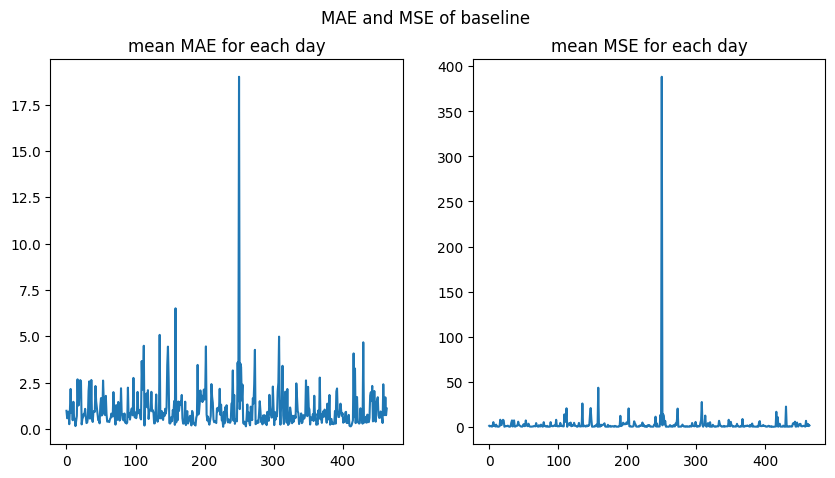

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(mae)
axs[0].set_title("mean MAE for each day")

axs[1].plot(mse)
axs[1].set_title("mean MSE for each day")

plt.suptitle("MAE and MSE of baseline")
plt.show()

In [7]:
results[250], ground_truth[250]

(array([241.91, 244.53, 247.19, 249.95, 252.73]),
 array([233.52, 232.78, 233.27, 233.37, 233.08]))

In [8]:
def get_strict_trend(arr):
    # Check for strictly increasing
    strictly_increasing = np.all(np.diff(arr, axis=1) > 0, axis=1)

    # Check for strictly decreasing
    strictly_decreasing = np.all(np.diff(arr, axis=1) < 0, axis=1)

    # Combine the two conditions
    is_monotone = strictly_increasing | strictly_decreasing
    print('Increasing:', strictly_increasing.mean())
    print('Decreasing:', strictly_decreasing.mean())
    print('Both:', is_monotone.mean())
    return strictly_increasing, strictly_decreasing, is_monotone

In [9]:
pred_trend = get_strict_trend(results)
ground_truth_trend = get_strict_trend(ground_truth)

Increasing: 0.8279569892473119
Decreasing: 0.08602150537634409
Both: 0.9139784946236559
Increasing: 0.05806451612903226
Decreasing: 0.04946236559139785
Both: 0.10752688172043011
